# Data Analytics Project 2

In [75]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [155]:
sp500 = (
    pd.read_csv(
        filepath_or_buffer='sp500.csv',
        parse_dates=['Date'],
        index_col=['Date']
    )
    .rename_axis(columns='Ticker')
)

sp500 = sp500[(sp500.index.year >= 1980)]

sp500['^GSPCret'] = sp500['^GSPC'].pct_change()

In [101]:
num_rows = sp500.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 11093


# Crisis periods

In [132]:
window_size = 252

sp500['Peak'] = sp500['^GSPC'].rolling(window=window_size, min_periods=1).max()
sp500['Trough'] = sp500['^GSPC'].rolling(window=window_size, min_periods=1).min()

sp500['Bear'] = (sp500['^GSPC'] - sp500['Peak']) / sp500['Peak']
sp500['Bull'] = (sp500['^GSPC'] - sp500['Trough']) / sp500['Trough']

bear_threshold = -0.2
bull_threshold = 0.2

sp500['Bear Market'] = sp500['Bear'] <= bear_threshold
sp500['Bull Market'] = sp500['Bull'] >= bull_threshold

sp500['In Crisis'] = False
in_crisis = False

for date, row in sp500.iterrows():
    if row['Bear Market'] and not in_crisis:
        in_crisis = True
    if row['Bull Market'] and in_crisis:
        in_crisis = False
    sp500.loc[date, 'In Crisis'] = in_crisis

number_of_trues = sp500['In Crisis'].sum()
print("Number of True values:", number_of_trues)



Number of True values: 1204


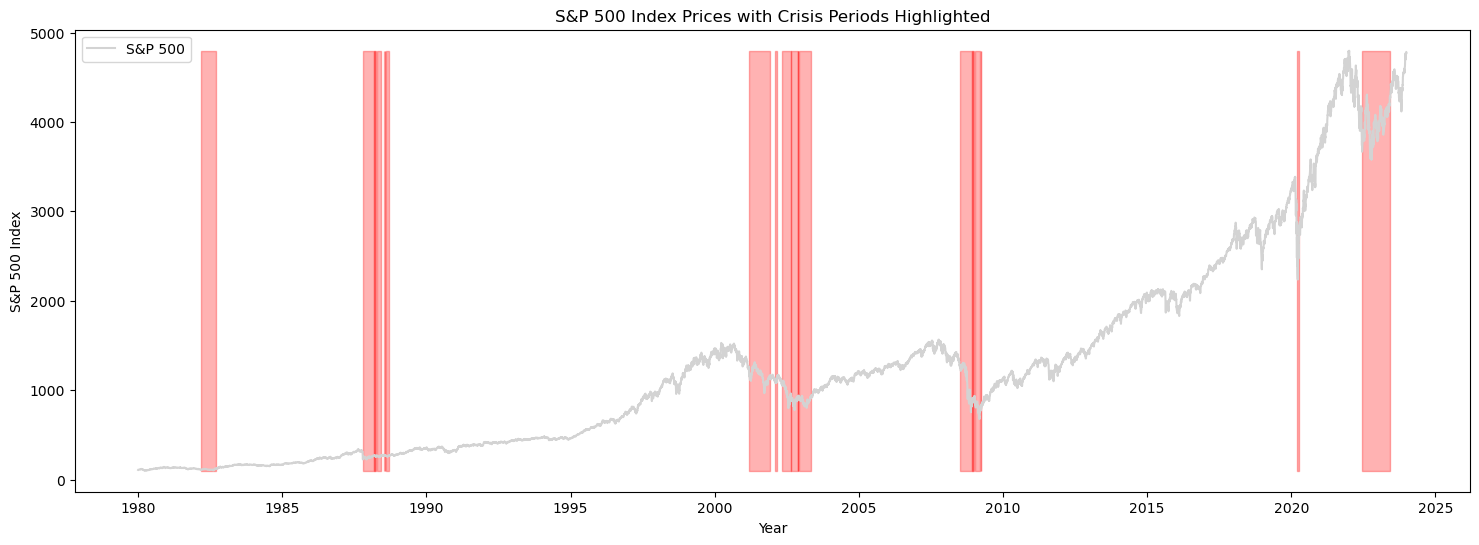

In [133]:

plt.figure(figsize=(18, 6))

plt.plot(sp500['^GSPC'], label='S&P 500', color='lightgray')

plt.fill_between(sp500.index, sp500['^GSPC'].min(), sp500['^GSPC'].max(), 
                 where=sp500['In Crisis'], color='red', alpha=0.3)

plt.xlabel('Year')
plt.ylabel('S&P 500 Index')
plt.title('S&P 500 Index Prices with Crisis Periods Highlighted')
plt.legend()


plt.show()

# Correlation 

In [134]:
crisis_data = sp500[sp500['In Crisis'] == True]
non_crisis_data = sp500[sp500['In Crisis'] == False]

crisis_data = crisis_data.drop(columns=['Peak', 'Trough', 'Bear', 'Bull', 'Bear Market', 'Bull Market', 'In Crisis', '^GSPC'])
non_crisis_data = non_crisis_data.drop(columns=['Peak', 'Trough', 'Bear', 'Bull', 'Bear Market', 'Bull Market', 'In Crisis', '^GSPC'])

crisis_correlations = crisis_data.corrwith(crisis_data['^GSPCret']).drop('^GSPCret')

non_crisis_correlations = non_crisis_data.corrwith(non_crisis_data['^GSPCret']).drop('^GSPCret')

crisis_corr_mean = crisis_correlations.mean()
non_crisis_corr_mean = non_crisis_correlations.mean()

crisis_corr_median = crisis_correlations.median()
non_crisis_corr_median = non_crisis_correlations.median()

print("\nNon-Crisis Period Correlation Mean:")
print(non_crisis_corr_mean)

print("Crisis Period Correlation Mean:")
print(crisis_corr_mean)

print("\nNon-Crisis Period Correlation Median:")
print(non_crisis_corr_median)

print("Crisis Period Correlation Median:")
print(crisis_corr_median)



Non-Crisis Period Correlation Mean:
0.4603602494769153
Crisis Period Correlation Mean:
0.6238411118673352

Non-Crisis Period Correlation Median:
0.46447983967877265
Crisis Period Correlation Median:
0.634053655639399


### Calculation of Correlations: 
Monthly returns for individual S&P 500 stocks and the index were used to calculate correlations.

### Results Interpretation: 
<li>The analysis reveals a significant correlation increase moving towards one during crisis periods. 
<li>The average correlation between individual stock returns and the S&P 500 index was 0.623 during crises compared to 0.460 during non-crisis periods. 
<li>The median correlations also exhibited a similar trend (0.634 vs. 0.464). 
<li>While correlations don’t strictly reach one, their tendency to be higher during a crisis suggests a rise in systemic risk and interconnectedness among stocks.

### Weaknesses and possible solutions
<ol>
    <li><b>Weakness:</b> The analysis relies only on daily returns for correlation calculations.<br>
    <b>Possible solution:</b> Correlation calculations on different time windows (e.g. hourly, 4-hourly etc) alongside daily calculations might reveal more detailed insights into how correlations evolve within a crisis period.</li>
    <li><b>Weakness:</b> Focusing solely on the S&P 500 limits the usefulness of the findings.<br>
    <b>Possible solution:</b>  Correlations between other asset classes (e.g. bonds, commodities, etc) during crises could be explored for a more comprehensive understanding of risk dynamics.</li>
    <li><b>Weakness:</b> While the 20% threshold approach is clear, it might be too rigid.<br>
    <b>Possible solution:</b> Implementing alternative crisis definitions (e.g. volatility thresholds, event studies) and comparing the correlation results across different crisis periods defined by these methods could benefit us in our findings.</li>
    <li><b>Weakness:</b> The analysis demonstrates a correlation increase, but it doesn’t necessarily prove that crises cause higher correlations.<br>
    <b>Possible solution:</b> Investigating alternative explanations for this correlation, such as investor behavior (e.g. herding, risk aversion) or market microstructure factors (e.g. liquidity chances, short selling) that might influence correlations during crises regardless of individual stock fundamentals could be helpful.</li>
</ol>

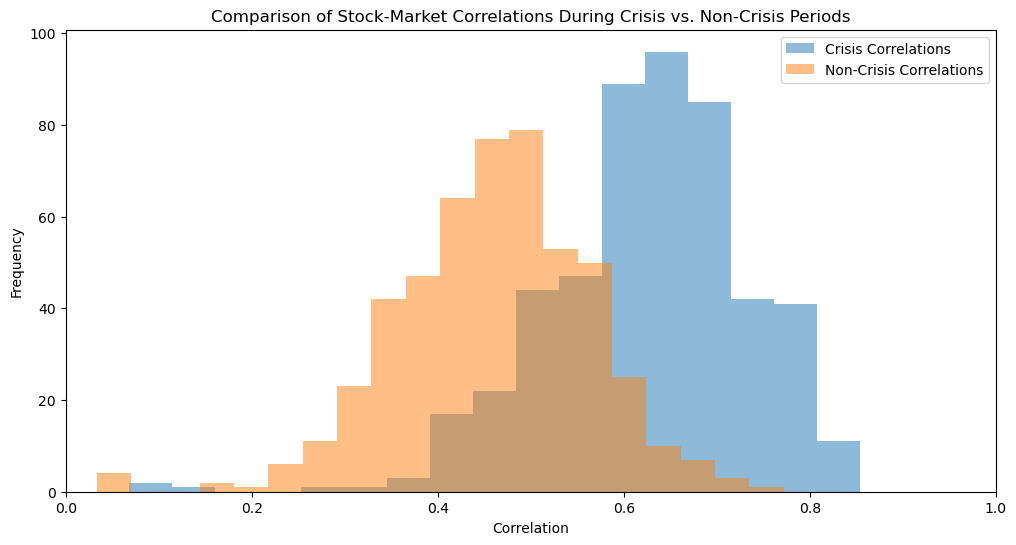

In [152]:
plt.figure(figsize=(12,6))

plt.hist(crisis_correlations, bins=20, alpha=0.5, label='Crisis Correlations')
plt.hist(non_crisis_correlations, bins=20, alpha=0.5, label='Non-Crisis Correlations')

plt.xlim(0, 1)

plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Comparison of Stock-Market Correlations During Crisis vs. Non-Crisis Periods')
plt.legend()

plt.show()

# CAPM Betas

In [138]:
def calculate_beta(df, market_col):
    market_variance = df[market_col].var()
    betas = {}
    for stock in df.columns.drop(market_col):
        covariance = df[[stock, market_col]].cov().iloc[0, 1]
        beta = covariance / market_variance
        betas[stock] = beta
    return pd.Series(betas)

betas_crisis = calculate_beta(crisis_data, '^GSPCret')
betas_non_crisis = calculate_beta(non_crisis_data, '^GSPCret')

betas_crisis_mean = betas_crisis.mean()
betas_non_crisis_mean = betas_non_crisis.mean()

betas_crisis_median = betas_crisis.median()
betas_non_crisis_median = betas_non_crisis.median()

print("\nNon-Crisis Period Beta Mean:")
print(betas_non_crisis_mean)

print("Crisis Period Beta Mean:")
print(betas_crisis_mean)

print("\nNon-Crisis Period Beta Median:")
print(betas_non_crisis_median)

print("Crisis Period Beta Median:")
print(betas_crisis_median)



Non-Crisis Period Beta Mean:
1.0385390328071238
Crisis Period Beta Mean:
1.0681680038374857

Non-Crisis Period Beta Median:
1.0031647226804912
Crisis Period Beta Median:
1.034890228171157


### CAPM Betas
Similar to correlations, CAPM betas also exhibit a distinct pattern during the crisis and non-crisis periods. The analysis reveals that crisis periods are associated with higher average and median CAPM betas compared to non-crisis periods.<p>
<b>CAPM Beta Mean:</b><br>
Crises: 1.068<br>
Non-Crisis: 1.038<br>
    
<b>CAPM Beta Median:</b><br>
Crisis: 1.034<br>
Non-Crisis: 1.003<br>

The visual representation with histograms further strengthens this observation (refer to CAPM beta distribution plot). The distribution of CAPM betas during a crisis leans towards higher values compared to the non-crisis period.
This phenomenon can be explained by the inherent nature of beta. Beta reflects a stock’s sensitivity to market movements. During economic downturns or crises, the overall market volatility increases. As a result, individual stocks tend to experience larger swings relative to the market movement. This heightened responsiveness to market fluctuations translates to higher CAPM betas for stocks during crisis periods.

The higher CAPM betas during crises signify an increase in risk for investors. When a stock has a beta greater than 1, it implies its returns are expected to be more volatile than the market. Therefore, during a crisis, these stocks are likely to experience even sharper declines than the broader market.

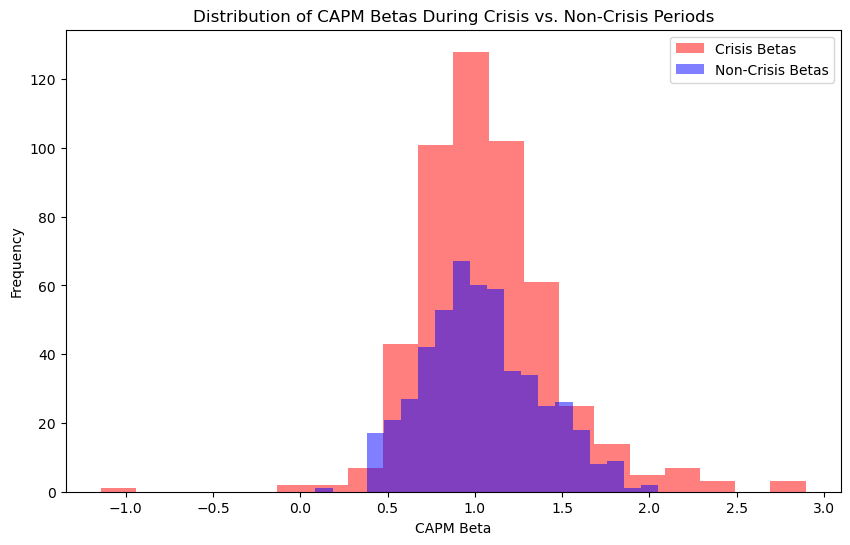

In [139]:
plt.figure(figsize=(10, 6))

plt.hist(betas_crisis, bins=20, alpha=0.5, label='Crisis Betas', color='red')
plt.hist(betas_non_crisis, bins=20, alpha=0.5, label='Non-Crisis Betas', color='blue')

plt.xlabel('CAPM Beta')
plt.ylabel('Frequency')
plt.title('Distribution of CAPM Betas During Crisis vs. Non-Crisis Periods')
plt.legend()

plt.show()

## Conclusion: 
Our analysis convincingly demonstrates that correlation between individual stock returns and the S&P 500 index is moving towards one during the crisis which indicates heightened systemic risk and interconnectedness among stocks.

Similarly, our findings reveal the same pattern for CAPM betas, with crisis periods associated with higher average and median betas compared to non-crisis periods. This underscores the increased sensitivity of individual stocks to market movements during economic downturns.

These insights provide valuable guidance for risk management and investment decisions in turbulent market environments, offering investors a clearer understanding of market dynamics during crisis. 